In [7]:
# importing libraries
 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import random
from scipy.optimize import curve_fit
import time

In [8]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [9]:
def infer_style():
    for style_name, style_params in plt.style.library.items():
        if all(key in plt.rcParams and plt.rcParams[key] == val for key, val in style_params.items()):
            return style_name
    return 'Default'


In [41]:
# huge python class with everything inside
#
# m = (m_r, m_g, m_b) 3 colors
# the grid is from (0,0) to (n,n) make NxN square, each is a 2 dim list, each vertex has an horizontal and vertical edges like so:
#               0
#             ----(x,y)
#                   |    1
#                   |
#
# the 4 directions are encoded as:
#                     0
#                  -------
#             3    |     |   1
#                  |_____|
#                     2
#

class stateSpace:
    def __init__(self, num_colors, grid_size, beta, init = 0, bc = 0, algo = 'metropolis'):  # 'glauber'      
    
        self.grid_size = grid_size
        self.V = grid_size**2
        self.num_colors = num_colors
        self.beta = beta
        self.data1 = []
        self.data2 = []
        self.data3 = []
        self.accepted = 0
        self.rejected = 0
        self.loops = 0
        self.algo = algo
        
        self.shape = (num_colors, grid_size+2, grid_size+2, 2)  #the +1 is for free bc  we work only on vertices from  (1,grid_size+1)

        self.grid = 2*np.random.randint(0, 10, self.shape, dtype=int) if bc == 'random' else bc*np.ones(self.shape, dtype=int)

        if init == 'random':
            self.random_init()
            
        else:
            self.uniform_init(init)

    def random_init(self):
        self.grid[:, 1:-1, 1:-1, :] = 2*np.random.randint(0, 10, size = (self.num_colors, self.grid_size, self.grid_size, 2), dtype=int)
        # bottom border
        self.grid[:, 1:-1, 0, 0] = 2*np.random.randint(0, 10, size = (self.num_colors, self.grid_size))
        # left border
        self.grid[:, 0, 1:-1, 1] = 2*np.random.randint(0, 10, size = (self.num_colors, self.grid_size))

    def uniform_init(self, k):
        self.grid[:, 1:-1, 1:-1, :] = k*np.ones((self.num_colors, self.grid_size, self.grid_size, 2), dtype=int)
        
    def step(self, num_steps = 1, progress_bar = True):   
        #print('using {} acceptance probability'.format(self.algo))
        for i in trange(num_steps, disable= not progress_bar):
            # store data
            if i % 10_000 == 0:                            # store data every 10k steps
                self.data1.append(self.get_avg_links()[0])
                self.data2.append(self.get_avg_local_time())
                loops = self.loop_builder()
                if len(loops) == 0:
                    self.data3.append(0)
                else:
                    lenghts = [len(l) for l in loops[0]]
                    self.data3.append(np.mean(lenghts))
                

            # choose a random color 
            c = np.random.randint(0, self.num_colors, dtype=int)
         
            # choose a random square
            s = np.random.randint(1, self.grid_size+1, size = 2, dtype=int)

            # get num_link on each side of square s
            S = np.zeros(4, dtype=int)
            S[0] = self.grid[c, s[0], s[1], 0]
            S[2] = self.grid[c, s[0], s[1]-1, 0]
            S[1] = self.grid[c, s[0], s[1], 1]
            S[3] = self.grid[c, s[0]-1, s[1], 1]

            # get list of all possible transformation
            transformations = self.get_possible_transformations(S)                    ############################ MINIMAL OR FULL ST ####################################
            #transformations = self.minimal_transformations(S)
            
            # pick uniformly a random transformation
            M = len(transformations)   # num of possible transformation of current state, compute only once! we also need it to compute tha ratio M/M_prime in acceptance_prob
            index = np.random.randint(0, M)  
            X = transformations[index]
            #print('transformation: {}'.format(X))
            
            if self.acceptance_prob(S, M, s, X) >= random.random():
                self.accepted += 1
                self.square_transformation(c, s, X)
            else:
                self.rejected += 1
    
    def minimal_transformations(self, S):
        # list of just minimal transformations for irreducibility

        transformations = [ 
            (1, 1, 1, 1),                      # uniform +1
            (-2, 0, 0, 0),                    # single top
            (0, -2, 0, 0),                    # single right
            (0, 0, -2, 0),                    # single bottom
            (0, 0, 0, -2)                    # single left
            ]    
        
        if S[0] < 2:                                                # top is 0 or 1, remove single top -2
            transformations.remove( (-2, 0, 0, 0) )
            
        if S[1] < 2:
            transformations.remove((0, -2, 0, 0))
           
        if S[2] < 2:
            transformations.remove((0, 0, -2, 0))
        
        if S[3] < 2:
            transformations.remove((0, 0, 0, -2))

        return transformations 
    
    def get_possible_transformations(self, S):
        # list of all possible transformations

        transformations = [ 
            (-1,-1,-1,-1),                    # uniform                     
            (-2, 0, 0, 0),                    # single top
            (0, -2, 0, 0),                    # single right
            (0, 0, -2, 0),                    # single bottom
            (0, 0, 0, -2),                    # single left
            (1,-1, 1,-1), (-1, 1,-1, 1),      # swap opposite
            (1, 1,-1,-1), (-1,-1, 1, 1),      # swap adjacent
            (-1, 1,1,-1), ( 1,-1,-1, 1)#,   
            #(1,-1,-1,-1), (-1, 1, 1, 1),      # triple up
            #(-1,1,-1,-1), ( 1,-1, 1, 1),      # triple right
            #(-1,-1,1,-1), ( 1, 1,-1, 1),      # triple bottom
           # (-1,-1,-1,1), ( 1, 1, 1,-1)       # triple left
            ]    
        
        if S[0] < 2:                                                # top is 0 or 1, remove single top -2
            transformations.remove( (-2, 0, 0, 0) )
            if S[0] == 0:                                           # top is 0, remove uniform -1, swap 
                transformations.remove((-1, -1, -1, -1))
                transformations.remove((-1, 1, -1, 1))
                transformations.remove((-1, -1, 1, 1))
                transformations.remove((-1, 1, 1, -1))
                #transformations.remove((-1, 1, 1, 1))
                #transformations.remove((-1, 1, -1, -1))
                #transformations.remove((-1, -1, 1, -1))
                #transformations.remove((-1, -1, -1, 1))
        if S[1] < 2:
            transformations.remove((0, -2, 0, 0))
            if S[1] == 0:
                if (-1, -1,-1,-1) in transformations: transformations.remove((-1, -1,-1,-1))
                if (1, -1, 1, -1) in transformations: transformations.remove(( 1, -1, 1,-1))
                if (-1, -1, 1, 1) in transformations: transformations.remove((-1, -1, 1, 1))
                if (1, -1, -1, 1) in transformations: transformations.remove(( 1, -1,-1, 1))
                #if (1, -1, -1, -1) in transformations: transformations.remove((1, -1, -1, -1))
                #if (1, -1, 1, 1) in transformations: transformations.remove((1, -1, 1, 1))
                #if (-1, -1, 1, -1) in transformations: transformations.remove((-1, -1, 1, -1))
                #if (-1, -1, -1, 1) in transformations: transformations.remove((-1, -1, -1, 1))

        if S[2] < 2:
            transformations.remove((0, 0, -2, 0))
            if S[2] == 0:
                if (-1, -1,-1,-1) in transformations: transformations.remove((-1,-1, -1,-1))
                if (-1, 1, -1, 1) in transformations: transformations.remove((-1, 1, -1, 1))
                if (1, 1, -1, -1) in transformations: transformations.remove(( 1, 1, -1,-1))
                if (1, -1, -1, 1) in transformations: transformations.remove(( 1,-1, -1, 1))
                #if (1, -1, -1, -1) in transformations: transformations.remove((1, -1, -1, -1))
                #if (-1, 1, -1, -1) in transformations: transformations.remove((-1, 1, -1, -1))
                #if (1, 1, -1, 1) in transformations: transformations.remove((1, 1, -1, 1))
                #if (-1, -1, -1, 1) in transformations: transformations.remove((-1, -1, -1, 1))
        
        if S[3] < 2:
            transformations.remove((0, 0, 0, -2))
            if S[3] == 0:
                if (-1, -1,-1,-1) in transformations: transformations.remove((-1,-1,-1, -1))
                if (1, -1, 1, -1) in transformations: transformations.remove(( 1,-1, 1, -1))
                if (1, 1, -1, -1) in transformations: transformations.remove(( 1, 1,-1, -1))
                if (-1, 1, 1, -1) in transformations: transformations.remove((-1, 1, 1, -1))
                #if (1, -1, -1, -1) in transformations: transformations.remove((1, -1, -1, -1))
                #if (-1, 1, -1, -1) in transformations: transformations.remove((-1, 1, -1, -1))
                #if (-1, -1, 1, -1) in transformations: transformations.remove((-1, -1, 1, -1))
                #if (1, 1, 1, -1) in transformations: transformations.remove((1, 1, 1, -1))


        return transformations + [(1, 1, 1, 1), (2, 0, 0, 0), (0, 2, 0, 0), (0, 0, 2, 0), (0, 0, 0, 2)]   #add back always applicable transformations

    def square_transformation(self, c, s, X):    # X = (a_1, a_2, a_3, a_4) like in the thesis
        #top
        self.grid[c, s[0], s[1], 0] += X[0]
        #right
        self.grid[c, s[0], s[1], 1] += X[1]
        #bottom
        self.grid[c, s[0], s[1]-1, 0] += X[2]
        #left
        self.grid[c, s[0]-1, s[1], 1] += X[3]
    
    def acceptance_prob(self, S, M, s, X):
        # possible transformation ratio
        S_prime = np.copy(S) 
        S_prime += np.array(X) #apply the transformation in the square

        #get M_prime, the number of possibile transformation of the new state
        M_prime = len(self.get_possible_transformations(S_prime))                                 ############################ MINIMAL OR FULL ST ####################################
        #M_prime = len(self.minimal_transformations(S_prime))

        # prob ratio
        match X:
            case (1, 1, 1, 1):
                A = self.beta**4 / (16 * (S[0] + 1)*(S[1] + 1)*(S[2] + 1)*(S[3] + 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1))*(self.num_colors/2 + self.get_local_time(s[0]-1 , s[1]))*(self.num_colors/2 + self.get_local_time(s[0]-1 , s[1]-1)))
            case (-1,-1,-1,-1):
                A = 16 / (self.beta**4) * S[0]*S[1]*S[2]*S[3] *(self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1 ) - 1)*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]-1) - 1)
            case (2, 0, 0, 0):
                A = self.beta**2/ (4*(S[0]+2)*(S[0]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]))  )
            case (-2, 0, 0, 0):
                A = 4 * S[0]*(S[0]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]) - 1)
            case (0, 2, 0, 0):
                A = self.beta**2/ (4*(S[1]+2)*(S[1]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]))*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1))  )
            case (0,-2, 0, 0): 
                A = 4 * S[1]*(S[1]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time(s[0], s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1) - 1)
            case (0, 0, 2, 0):
                A = self.beta**2/ (4*(S[2]+2)*(S[2]+1)*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1))*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1))  )
            case (0, 0,-2, 0):
                A = 4 * S[2]*(S[2]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1 ) - 1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1 ) - 1)
            case (0, 0, 0, 2):
                A = self.beta**2/ (4*(S[3]+2)*(S[3]+1)*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]))*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1))  )
            case (0, 0, 0,-2):
                A = 4 * S[3]*(S[3]-1) / self.beta**2 * (self.num_colors/2 + self.get_local_time( s[0]-1, s[1]) - 1)*(self.num_colors/2 + self.get_local_time( s[0]-1, s[1]-1) - 1)
            
            case (-1, 1, -1, 1):
                A = S[0]*S[2]/( (S[1]+1)*(S[3]+1) )
            case (1, -1, 1, -1):
                A = S[1]*S[3]/( (S[0]+1)*(S[2]+1) )
            case (-1, -1, 1, 1):
                A = S[0]*S[1] / ( (S[2]+1)*(S[3]+1) *(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]-1) + 1 )*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]-1)) )*(self.num_colors/2 + self.get_local_time(s[0],s[1]) - 1)*(self.num_colors/2 + self.get_local_time(s[0],s[1]) - 2)
            case (1, 1, -1, -1):
                A = S[2]*S[3] / ( (S[0]+1)*(S[1]+1) *(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]-1) -1 )*(self.num_colors/2 + self.get_local_time(s[0]-1, s[1]-1) -2 ) )*(self.num_colors/2 + self.get_local_time(s[0],s[1]) + 1)*(self.num_colors/2 + self.get_local_time(s[0],s[1]) )
            case (-1, 1, 1, -1):
                A = S[0]*S[3] / (  (S[1]+1)*(S[2]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1) -1 )*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1) -2 ) ) *(self.num_colors/2 + self.get_local_time(s[0]-1,s[1]) + 1)*(self.num_colors/2 + self.get_local_time(s[0]-1,s[1]) )
            case (1, -1, -1, 1):
                A = S[2]*S[1] / (  (S[3]+1)*(S[0]+1)*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1) +1 )*(self.num_colors/2 + self.get_local_time(s[0], s[1]-1) ) ) *(self.num_colors/2 + self.get_local_time(s[0]-1,s[1]) -1)*(self.num_colors/2 + self.get_local_time(s[0]-1,s[1]) - 2)

            # missing triple transformations

        #print('acceptance prob = {}'.format(min(1, M/M_prime * A)))
        return min(1, M/M_prime * A) if self.algo == 'metropolis' else 1/(1 + M_prime/(M*A))   # Metropolis  Glauber       #### May impact performanca a bit, better to edit the code!
    
    def get_local_time(self, x, y):   # we know already the number of links in square s! we are wasting a bit of compute power 
        local_time = 0
        for c in range(self.num_colors):
            local_time += self.grid[c, x, y, 0] + self.grid[c, x, y, 1] + self.grid[c, x, y + 1, 1] + self.grid[c, x + 1, y, 0]
        return local_time // 2

    def get_max_links(self):
        max_links = np.zeros(self.num_colors)
        for c in range(0,self.num_colors):
            for x in range(1,self.grid_size+1):
                for y in range(1,self.grid_size+1):
                    if self.grid[c, x, y, 0] >= max_links[c]:
                        max_links[c] = self.grid[c, x, y, 0]
                    if self.grid[c, x, y, 1] >= max_links[c]:
                        max_links[c] = self.grid[c, x, y, 1]
        return max_links
    
    def get_avg_links(self):
        avg_links = np.zeros(self.num_colors)
        for c in range(self.num_colors):
            avg_links[c] = np.mean(self.grid[c, 1:-1, 1:-1, :])
        return avg_links

    def get_avg_local_time(self):
        total_local_time = 0
        for x in range(1,self.grid_size+1):
            for y in range(1,self.grid_size+1):
                total_local_time += self.get_local_time(x,y)
        return total_local_time / self.V
    
    def loop_builder(self):  # given a link configuration, randomly builds loops (we are choosing a link pairing uniformly) returns list of loops (as a sequence of vertices) for each color
        loops = []
        for c in range(self.num_colors):
            color_loops = []
            #copy the grid 
            G = np.copy(self.grid[c])
            nz = G.nonzero()
            non_zero = len(nz[0])
            if non_zero == 0:
                    return []
            
            while non_zero > 0:
                #pick first non-zero and unvisited edge
                nz = G.nonzero()
                non_zero = len(nz[0])
                if non_zero == 0:
                    break
                # choose a random vertex with non-zero incident links 
                rand_index = np.random.randint(0, non_zero)
                x, y  = nz[0][rand_index], nz[1][rand_index]
                starting_vertex = (x,y)
                current_loop = []
                
                # first step outside loops
                dir = []
                
                top = G[x,y+1,1]
                right = G[x+1,y,0]
                bottom = G[x,y,1]
                left = G[x,y,0]
                
                if top > 0:
                    dir.extend([0]*top)
                elif right > 0:
                    dir.extend([1]*right)
                elif bottom > 0:
                    dir.extend([2]*bottom)
                elif left > 0:
                    dir.extend([3]*left)
                
                # pick a random dir with prob prop to num_links  
                rand_dir = np.random.choice(dir)
                
                match rand_dir:
                    case 0:
                        # remove one link
                        G[x,y+1,1] -= 1
                        #move there
                        y += 1
                    case 1:
                        G[x+1,y,0] -= 1
                        x += 1
                    case 2:
                        G[x,y,1] -= 1
                        y -= 1
                    case 3:
                        G[x,y,0] -= 1
                        x -= 1
                
                while True:
                    current_loop.append((x,y))
                    # look if we can trav in each of the 4 directions: top = 0, right = 1, down = 2 and left = 3 with prob eq. to num_links/Z
                    dir = []
                    
                    top = G[x,y+1,1]
                    right = G[x+1,y,0]
                    bottom = G[x,y,1]
                    left = G[x,y,0]
                    
                    if top > 0:
                        dir.extend([0]*top)
                    elif right > 0:
                        dir.extend([1]*right)
                    elif bottom > 0:
                        dir.extend([2]*bottom)
                    elif left > 0:
                        dir.extend([3]*left)

                    if (x,y) == starting_vertex:
                        if random.random() <= 1/(len(dir)+1):
                            break
                    
                    # pick a random dir with prob prop to num_links  
                    rand_dir = np.random.choice(dir)
                    
                    match rand_dir:
                        case 0:
                            # remove one link
                            G[x,y+1,1] -= 1
                            #move there
                            y += 1
                        case 1:
                            G[x+1,y,0] -= 1
                            x += 1
                        case 2:
                            G[x,y,1] -= 1
                            y -= 1
                        case 3:
                            G[x,y,0] -= 1
                            x -= 1
                        
                color_loops.append(current_loop)
            loops.append(color_loops)
        return loops
                
    def check_state(self): # checks if the current state m is legal (every vertex has even degree)
        for c in range(self.num_colors):
            for x in range(1,self.grid_size+1):
                for y in range(1,self.grid_size+1):
                    if (self.grid[c, x, y, 0] + self.grid[c, x, y, 1] + self.grid[c, x, y + 1, 1] + self.grid[c, x + 1, y, 0]) % 2 != 0:
                        print('###  illegal state!  ###')
                        return False 
        return True 
    def plot_one_color(self, c, cmap, ax, alpha = 1.0): # plots the grid of just one color
        for x in range(0, self.grid_size+2):
                for y in range(0, self.grid_size+2):
                    # horizontal
                    if self.grid[c,x,y,0] != 0:
                        edge_color = cmap(self.grid[c,x,y,0])
                        ax.plot([x-1, x], [y, y], color=edge_color,linewidth=1.5, alpha = alpha)
                    # vertical
                    if self.grid[c,x,y,1] != 0:   
                        edge_color = cmap(self.grid[c,x,y,1])
                        ax.plot([x, x], [y, y-1], color=edge_color, linewidth=1.5, alpha = alpha)
        
    def plot_loop(self, c, loop, color = 'yellow', alpha = 0.25):  # plots the longest loop over the grid
        fig, ax = plt.subplots(figsize=(12,12))
        num_segments = int(self.get_max_links()[c]+1)            #color dependet!
        cmap = create_cmap(c, num_segments)
        self.plot_one_color(c, cmap, ax)
        for i in range(len(loop)-1):
            ax.plot( [loop[i][0], loop[i+1][0]], [loop[i][1], loop[i+1][1]], linewidth=1.5, color = color, alpha = alpha)
        #draw last link
        ax.plot( [loop[0][0], loop[-1][0]], [loop[0][1], loop[-1][1]], linewidth=1.5, color = color, alpha = alpha)
        ax.set_title('length = {}'.format(len(loop)))
        
    def plot_grid(self, figsize=(32, 8), colorbar = True, file_name = None):     # plots the grid of every color 
        fig, axes = plt.subplots(1,self.num_colors,figsize = figsize, gridspec_kw={'hspace': 0.05, 'wspace': 0.05}) #, facecolor='black')
        # Adjust the space between subplots
        for c in range(self.num_colors):
            # Define a colormap
            num_segments = int(self.get_max_links()[c]+1)            #color dependet!
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            self.plot_one_color(c, cmap, axes[c])
            #axes[c].set_title('avg links = {}'.format(self.get_avg_links()[c]))
            axes[c].set_xlim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            axes[c].set_ylim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            #axes[c].axis('square')
            axes[c].axis('off')                                                ########### axis
            
            # Add colorbar
            if colorbar:
                # Add colorbar
                cbar = plt.colorbar(sm, ax=axes[c])
                cbar.set_ticks(  0.5 + np.arange(0, num_segments,1))
                cbar.set_ticklabels(list(range(0, num_segments)))
                #cbar.set_label('Color Mapping')

        fig.suptitle(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()

    def plot_overlap(self, figsize = (12,12), normalized = False, file_name = None):  # plots every color overlapped
        # Create a figure and axes
        fig, ax = plt.subplots(figsize = figsize)

        for c in range(self.num_colors):
            # Define a colormap
            num_segments = int(self.get_max_links()[c]+1) if not normalized else 2
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            self.plot_one_color(c, cmap, ax, 0.6)
            ax.set_title(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
            ax.set_xlim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            ax.set_ylim(-(1+0.05*self.grid_size), 2+self.grid_size*1.05)
            #ax.axis('square')
            ax.axis('off')
    
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()
    
    def summary(self):   # prints some stats
        print('average number of links: {}'.format(self.get_avg_links()[0]))
        print('max number of links: {}'.format(self.get_max_links()[0]))
        print('avg local time: {}'.format(self.get_avg_local_time()))
        loops = self.loop_builder()[0] #stats on color 0
        lenghts = [len(l) for l in loops]
        print('avg loop length: {}'.format(np.mean(lenghts)))
        print('max loop length: {}'.format(max(lenghts)))
        print('steps = {:g}   acceptance ratio = {:.6f}'.format(self.accepted + self.rejected, self.accepted / (self.accepted + self.rejected)))
        
    
def create_cmap(color, n_bins):  # create a color map to show how many links are in a edge
    # get current style
    current_style = infer_style()
    start = (0,0,0) if current_style == 'dark_background' else (1,1,1)
    if color == 0:
        colors = [start, (1, 0, 0)]  # RGB values  
    if color == 1:
        colors = [start, (0, 1, 0)]  # RGB values
    if color == 2:
        colors = [start, (0, 0, 1)]  # RGB values

    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=n_bins)
    return cmap


  0%|          | 0/1000000 [00:00<?, ?it/s]

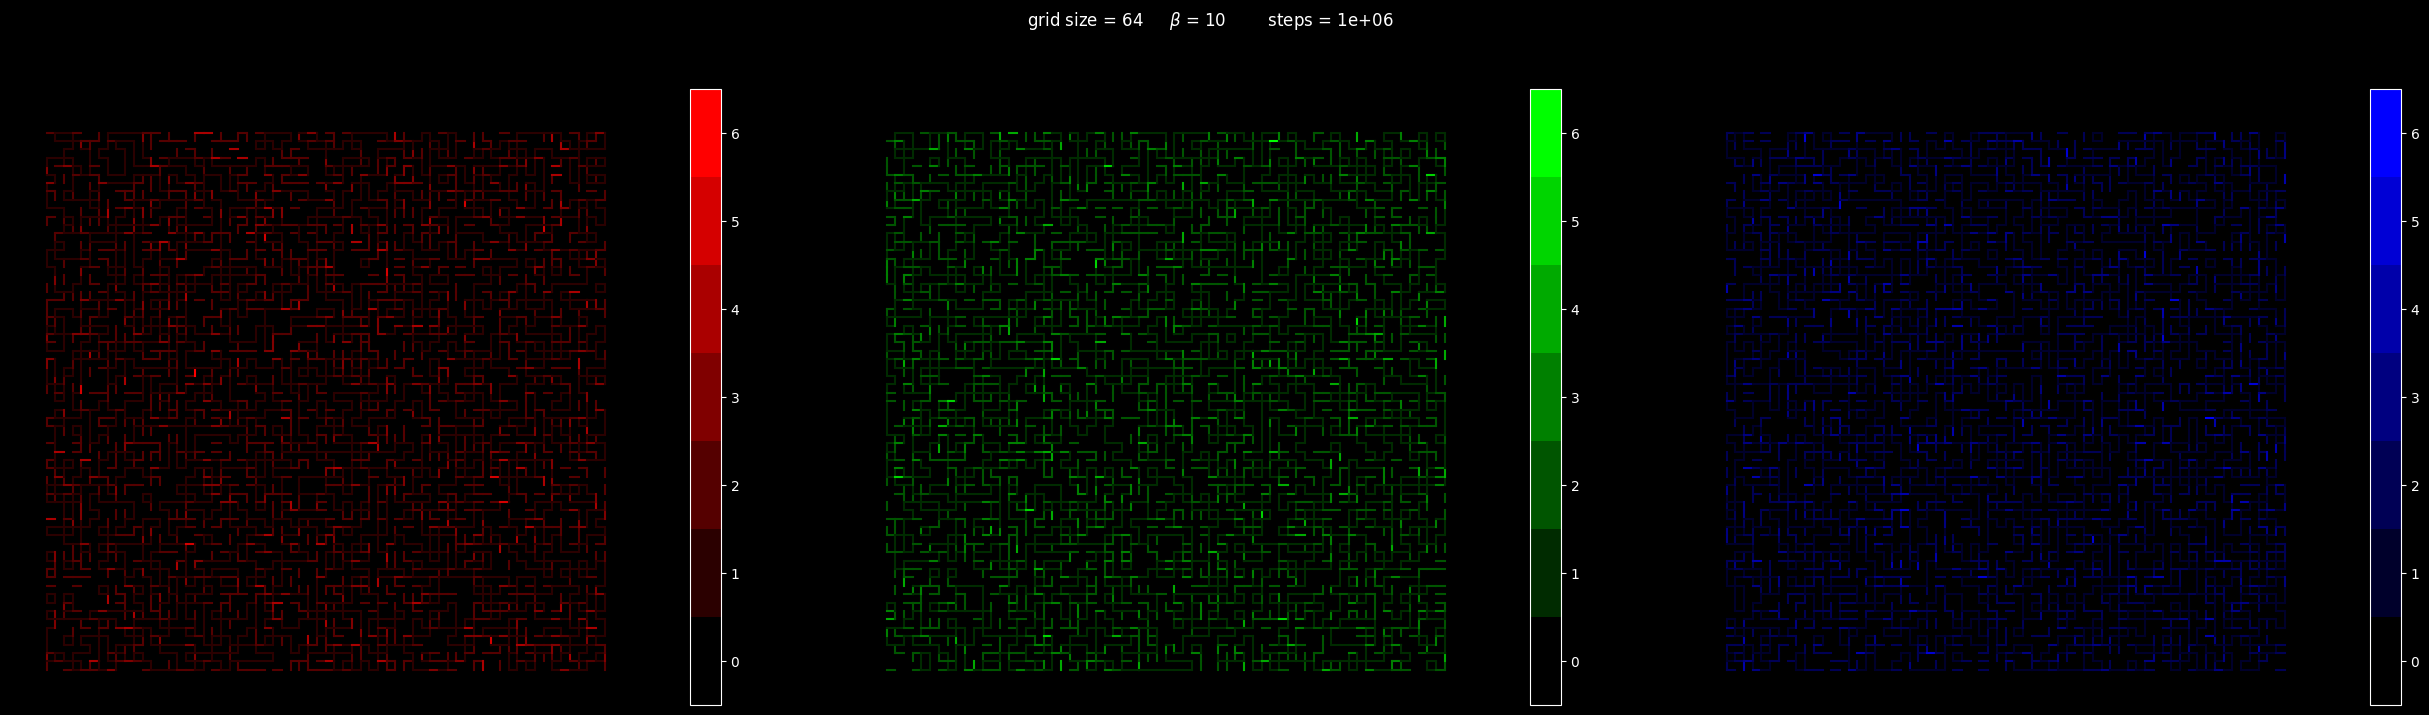

average number of links: 0.8291015625
max number of links: 6.0
avg local time: 4.9765625
avg loop length: 12.718232044198896
max loop length: 3910
steps = 1e+06   acceptance ratio = 0.265239


In [51]:
# initialize the grid
m = stateSpace(num_colors = 3, grid_size = 64, beta = 10 , init = 0, bc = 0, algo='glauber')  

# run it
m.step(1_000_000)  # about 3 seconds for 100k steps on my PC

# plot it
plt.style.use("dark_background")
m.plot_grid() #, file_name = '64_0_9_U2.pdf')

#sample loops
loops = m.loop_builder()

m.summary()

# Equilibrium check

We sample every $10k$ steps the average number of links, average local time and average loop length. We plot these values normalized as a functions of time to check if the chain has reached equilibrium.

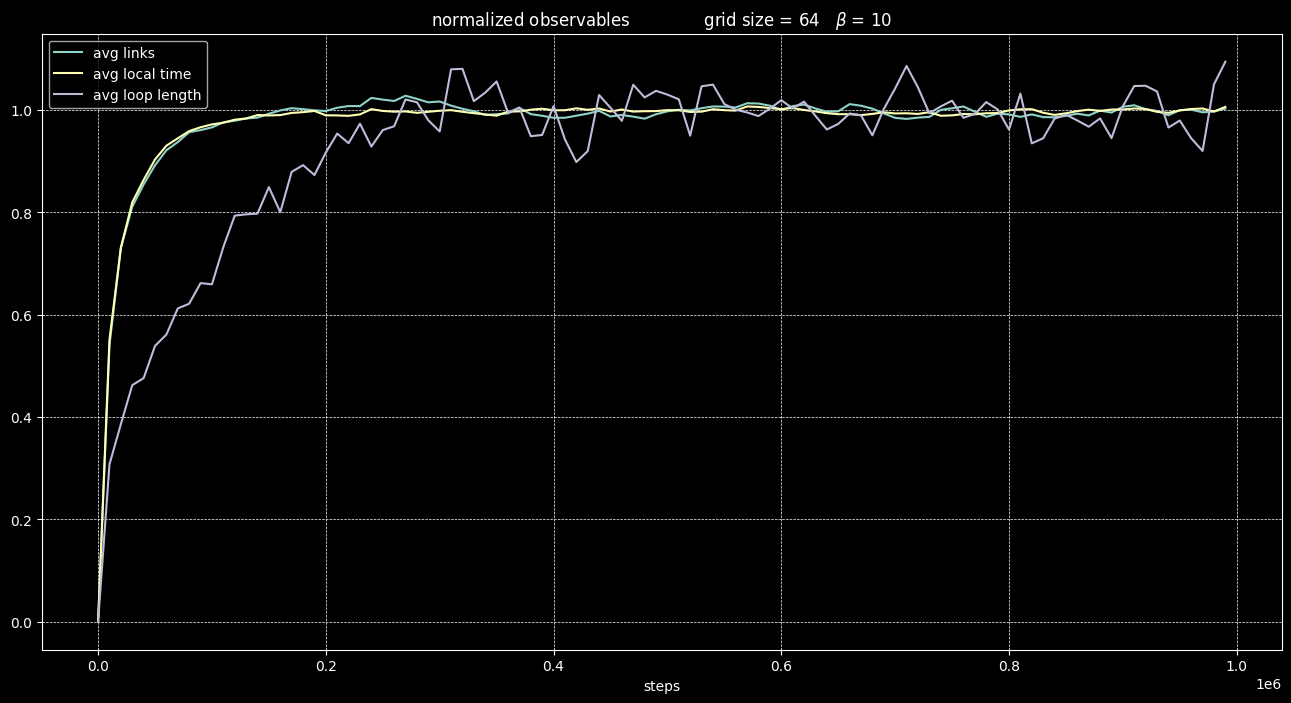

In [68]:
# plot relevant observables normalized to last value

# steps
x = np.arange(0, 1_000_000, 10_000)  # we sampled every 10k steps

# normalize with avg of last 10 values 
n1 = np.mean(m.data1[-10:-1])
n2 = np.mean(m.data2[-10:-1])
n3 = np.mean(m.data3[-10:-1])

plt.figure(figsize=(16,8))
plt.plot(x, np.array(m.data1) / n1 , label = 'avg links')
plt.plot(x, np.array(m.data2) / n2, label = 'avg local time')
plt.plot(x, np.array(m.data3) / n3, label = 'avg loop length')
plt.legend()
plt.xlabel('steps')
plt.title(r'normalized observables              grid size = {}   $\beta$ = {}'.format(m.grid_size, m.beta))
plt.grid(linewidth=0.5, linestyle = '--')

In [38]:
m.data3

[]

# Loops

11.256410256410257

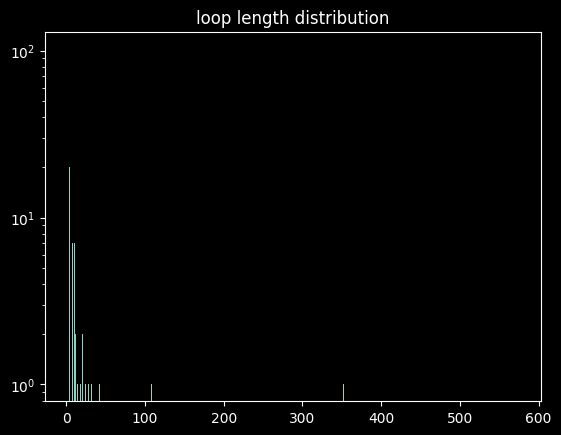

In [39]:
# choose a color
color = 0

lenghts = [len(l) for l in loops[color]]

plt.hist(lenghts, log = True, align='left', bins = range(min(lenghts), max(lenghts) + 2, 1))
plt.title('loop length distribution')
np.mean(lenghts)

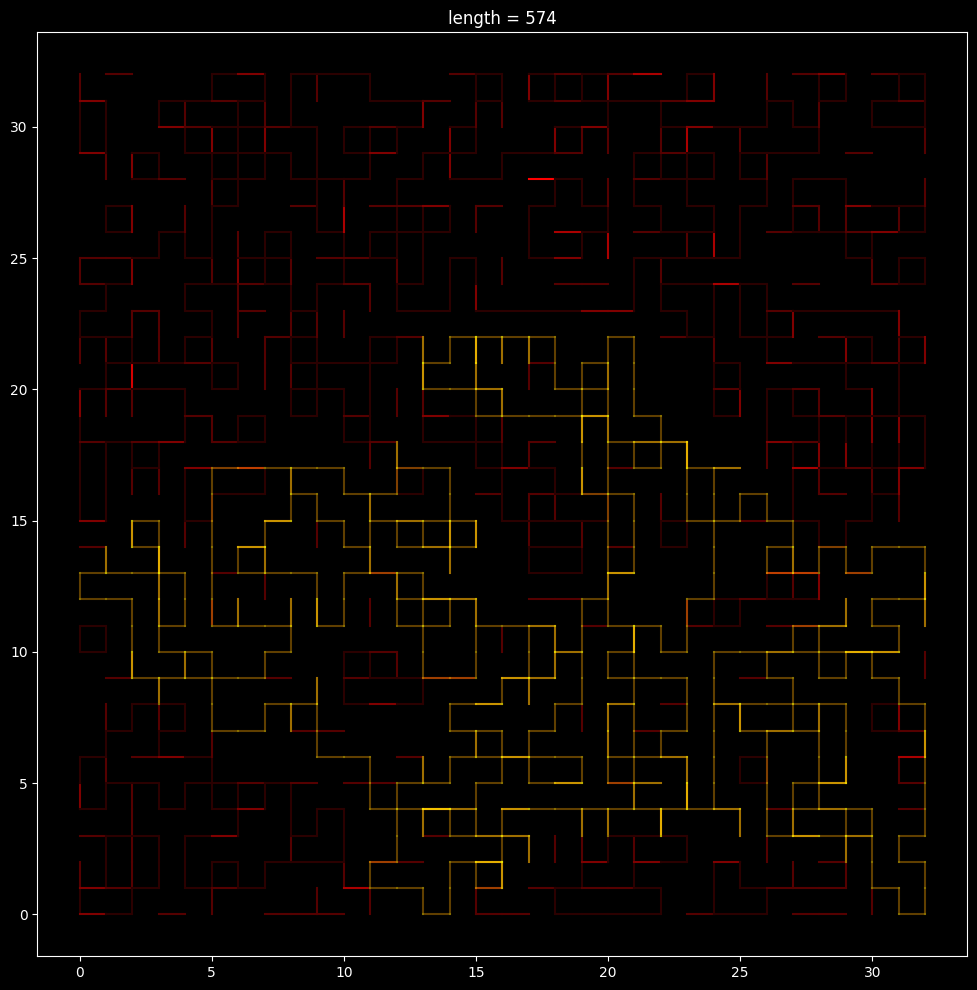

In [40]:
# find longest loop
max_length = max(lenghts)

longest_loop =  []

for l in loops[color]:
    if len(l) == max_length:
        longest_loop = l

#plot it 
m.plot_loop(color, longest_loop)

# Sampling

In [58]:

beta = 3
num_samples = 10
steps = 100_000
lenghts = []
mean_lengths = []
max_lengths = []
local_times = []

m = stateSpace(num_colors = 3, grid_size = 32, beta = beta , init = 0, bc = 0, algo='metropolis')  #(num_colors = 3, grid_size = 10, beta = 1, uniform_init = False)  #0.1875
m.step(100_000)

for i in trange(num_samples):
   
    m.step(steps, progress_bar=False)
    
    #loops
    loops = m.path_builder()

    # choose a color
    color = 0

    # compute lenghts
    lens = [len(l) for l in loops[color]]

    # find longest loop
    max_lengths.append(max(lens))
    lenghts.extend(lens)
    mean_lengths.append(np.mean(lens))
    

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(array([0.06895581, 0.00211089, 0.00070363, 0.00105545, 0.        ,
        0.00035182, 0.        , 0.        , 0.        , 0.00035182]),
 array([  2. ,  15.6,  29.2,  42.8,  56.4,  70. ,  83.6,  97.2, 110.8,
        124.4, 138. ]),
 <BarContainer object of 10 artists>)

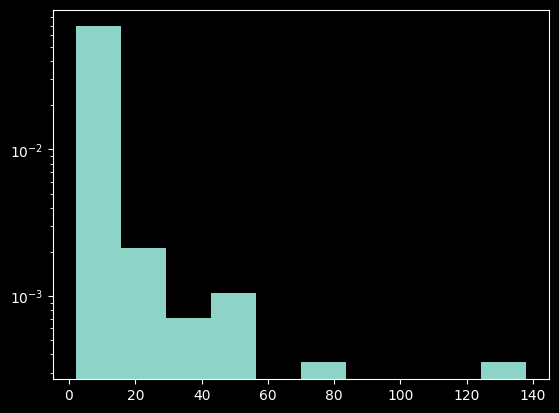

In [75]:
plt.hist(lenghts, log = True, density = True)

# Animations

In [5]:
def plot_one(grid, c, cmap, ax, alpha = 1.0):
        for x in range(0, len(grid[0])):
                for y in range(0, len(grid[0])):
                    # horizontal
                    if grid[c,x,y,0] != 0:
                        edge_color = cmap(grid[c,x,y,0])
                        ax.plot([x-1, x], [y, y], color=edge_color,linewidth=1.5, alpha = alpha)
                    # vertical
                    if grid[c,x,y,1] != 0:   
                        edge_color = cmap(grid[c,x,y,1])
                        ax.plot([x, x], [y, y-1], color=edge_color, linewidth=1.5, alpha = alpha)


def plot_over(i):
        figsize = (12,12) 
        normalized = False
        file_name = None
        grid_size = len(m.data1[0][0])
        # Create a figure and axes
        fig, ax = plt.subplots(figsize = figsize)

        for c in range(3):
            # Define a colormap
            num_segments = int(np.max(m.data1[i][c]) + 1) if not normalized else 2
            cmap = create_cmap(c, num_segments)
            
            # Create a ScalarMappable for colorbar
            norm = Normalize(vmin=0, vmax=num_segments)
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Empty array, as we'll not use actual data

            plot_one(m.data1[i], c, cmap, ax, 0.6)
            #ax.set_title(r'grid size = {}     $\beta$ = {}        steps = {:g}'.format(self.grid_size, self.beta, self.accepted + self.rejected))
            ax.set_xlim(-(1+0.05*grid_size), 2+grid_size*1.05)
            ax.set_ylim(-(1+0.05*grid_size), 2+grid_size*1.05)
            #ax.axis('square')
            ax.set_title('step {}'.format( int(i*10_000)) )
            ax.axis('off')
    
        #save it
        if file_name != None:
            plt.savefig(file_name)
        plt.show()
'''
def anim_plotter(i):
    fig, ax = plt.subplots(figsize = (14,10)) 
    # Adjust the space between subplots

    # Define a colormap
    num_segments = np.max(m.data1[i][0])            #color dependet!
    cmap = create_cmap(0, num_segments)

    # Create a ScalarMappable for colorbar
    norm = Normalize(vmin=0, vmax=num_segments)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array, as we'll not use actual data

    grid_size = len(m.data1[0][0])

    plot_one(m.data1[i], 0, cmap, ax)
    #axes[c].set_title('avg links = {}'.format(self.get_avg_links()[c]))
    ax.set_xlim(-(1+0.05*grid_size), 2+grid_size*1.05)
    ax.set_ylim(-(1+0.05*grid_size), 2+grid_size*1.05)
    
    #axes[c].axis('square')
    #plt.show()
'''

"\ndef anim_plotter(i):\n    fig, ax = plt.subplots(figsize = (14,10)) \n    # Adjust the space between subplots\n\n    # Define a colormap\n    num_segments = np.max(m.data1[i][0])            #color dependet!\n    cmap = create_cmap(0, num_segments)\n\n    # Create a ScalarMappable for colorbar\n    norm = Normalize(vmin=0, vmax=num_segments)\n    sm = ScalarMappable(cmap=cmap, norm=norm)\n    sm.set_array([])  # Empty array, as we'll not use actual data\n\n    grid_size = len(m.data1[0][0])\n\n    plot_one(m.data1[i], 0, cmap, ax)\n    #axes[c].set_title('avg links = {}'.format(self.get_avg_links()[c]))\n    ax.set_xlim(-(1+0.05*grid_size), 2+grid_size*1.05)\n    ax.set_ylim(-(1+0.05*grid_size), 2+grid_size*1.05)\n    \n    #axes[c].axis('square')\n    #plt.show()\n"

In [7]:
%matplotlib inline
from ipywidgets import interact

# Create an interactive slider from 0 to 99
interact(plot_over, i=(0, 9))


interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_over(i)>

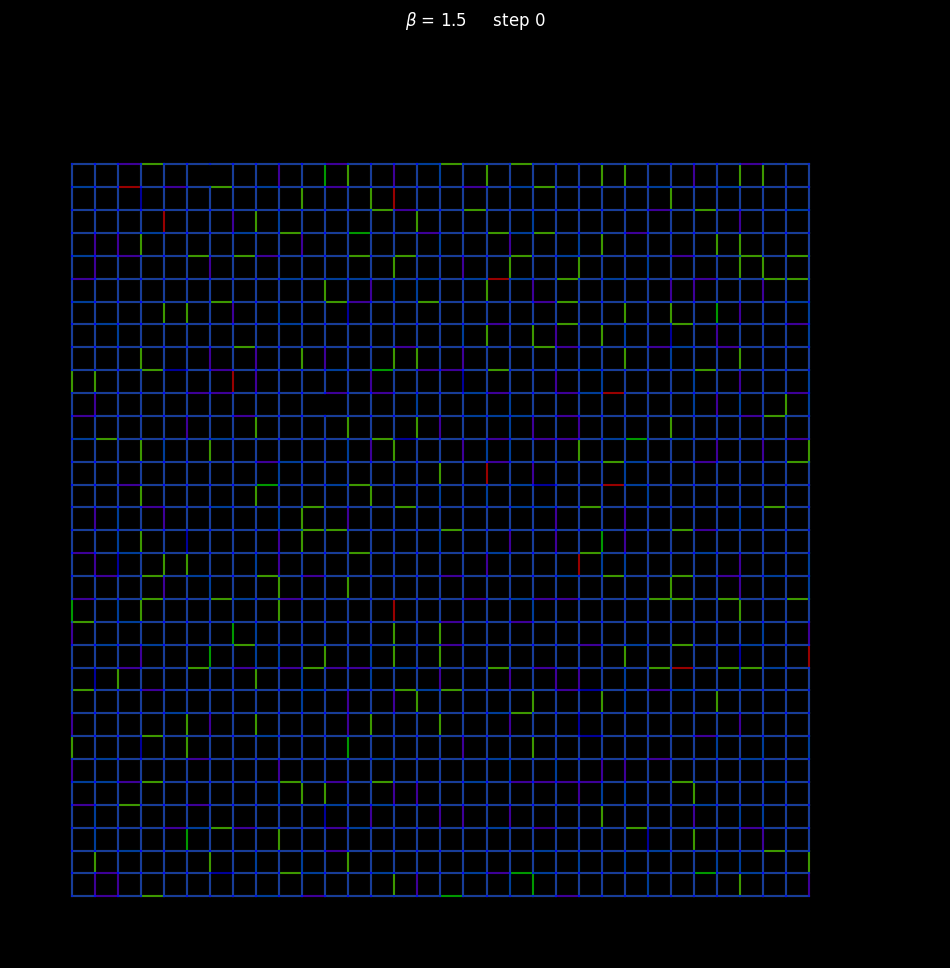

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

def plot_over(i, m, ax):
    normalized = True
    grid_size = len(m.data1[0][0])

    ax.clear()

    for c in range(3):
        num_segments = int(np.max(m.data1[i][c]) + 1) if not normalized else 2
        cmap = create_cmap(c, num_segments)

        norm = Normalize(vmin=0, vmax=num_segments)
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        plot_one(m.data1[i], c, cmap, ax, 0.6)
        ax.set_xlim(-(1 + 0.05 * grid_size), 2 + grid_size * 1.05)
        ax.set_ylim(-(1 + 0.05 * grid_size), 2 + grid_size * 1.05)
        ax.set_title(r'$\beta$ = {}     step {}'.format(1.5, int(i * 10_000))) ###
        ax.axis('off')

fig, ax = plt.subplots(figsize=(12, 12))

# You may need to adjust the range and interval based on your data and desired animation speed
animation = FuncAnimation(fig, lambda i: plot_over(i, m, ax), frames=len(m.data1), interval=250, repeat=False)

# Display the animation in the notebook
HTML(animation.to_jshtml())


In [8]:
m.check_state()

True

In [16]:
transformations = [ 
            (1, 1, 1, 1), (-1,-1,-1,-1),      # uniform                        #add later transformation that we can always apply!!!
            (2, 0, 0, 0), (-2, 0, 0, 0),      # single top
            (0, 2, 0, 0), (0, -2, 0, 0),      # single right
            (0, 0, 2, 0), (0, 0, -2, 0),      # single bottom
            (0, 0, 0, 2), (0, 0, 0, -2),      # single left
            (1,-1, 1,-1), (-1, 1,-1, 1),      # swap opposite
            (1, 1,-1,-1), (-1,-1, 1, 1),      # swap adjacent
            (-1, 1,1,-1), ( 1,-1,-1, 1),   
            (1,-1,-1,-1), (-1, 1, 1, 1),      # triple up
            (-1,1,-1,-1), ( 1,-1, 1, 1),      # triple right
            (-1,-1,1,-1), ( 1, 1,-1, 1),      # triple bottom
            (-1,-1,-1,1), ( 1, 1, 1,-1)       # triple left
            ]    

for t in transformations:
    if t[3] < 0:
        print('if {} in transformations: transformations.remove({})'.format(t,t))

if (-1, -1, -1, -1) in transformations: transformations.remove((-1, -1, -1, -1))
if (0, 0, 0, -2) in transformations: transformations.remove((0, 0, 0, -2))
if (1, -1, 1, -1) in transformations: transformations.remove((1, -1, 1, -1))
if (1, 1, -1, -1) in transformations: transformations.remove((1, 1, -1, -1))
if (-1, 1, 1, -1) in transformations: transformations.remove((-1, 1, 1, -1))
if (1, -1, -1, -1) in transformations: transformations.remove((1, -1, -1, -1))
if (-1, 1, -1, -1) in transformations: transformations.remove((-1, 1, -1, -1))
if (-1, -1, 1, -1) in transformations: transformations.remove((-1, -1, 1, -1))
if (1, 1, 1, -1) in transformations: transformations.remove((1, 1, 1, -1))
